In [33]:
from ipywidgets import IntProgress
from IPython.display import display
import time

from covid19_vulnerabilidad_mex.datos import *
from covid19_vulnerabilidad_mex.vulnerabilidad import *

import pandas as pd
import geopandas as gpd

import glob
import os
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.text import Text
import numpy as np
import plotly.express as px

from datetime import timedelta
import datetime
from datetime import timedelta, date, datetime
import pickle

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cross_decomposition import PLSRegression

import seaborn as sns
import imageio
from pygifsicle import optimize

plt.style.use('ggplot')

## Variables de análisis

* fecha_corte: la última fecha en la que se actualizó la base
* método: PLS
* ventana_dias: 28

En esta primera celda fijamos los parámetros y calculamos los modelos y las series de tiempo de vulnerabilidad

In [138]:
fecha_corte = datetime.strptime('9-03-21', "%d-%m-%y").date()
antier = fecha_corte - timedelta(days=2)
fecha_analisis = antier - timedelta(weeks=2)
fecha_analisis = pd.to_datetime(fecha_analisis)
metodo = 'PLS'
ventana_dias = 28
inicio = pd.to_datetime('20-03-15', yearfirst=True)
fin = antier - timedelta(days=7)
# leemos los datos de un pickle ya calculado para el dia de fecha_corte
serie_municipal = pickle.load( open( "datos/serie_municipal_reclasificada_9-03-21.pkl", "rb" ) )
modelos, serie = periodo_vulnerabilidad_con_dataframe(
            serie_municipal,
            inicio,
            fin,
            min_casos=10,
            columna='covid_defun_100k',
            rf=False
        )

IntProgress(value=0, max=350)

## Postprocesamiento

* Tomamos el valor absoluto de los coeficientes. El signo nos indica el sentido de la rotación y no aporta información 
* Reescalamos (min max) la vulnerabilidad de los municipios. Esamos interesados en las diferencias, no realmente en el valor
* Calculamos la vulnerabilidad para cada estado (promedio ponderado por población de las vulnerabilidades de los municipios de cada estado)
* Normalizamos la vulnerabilidad para los estados

In [139]:
modelos['coef'] = modelos['coef'].abs()
serie = rescala_min_max(serie, 'valor_covid_defun_100k')
serie = agregar_vulnerabilidad_entidades(serie, 'valor_covid_defun_100k')
serie = rescala_min_max(serie, 'valor_covid_defun_100k_entidad')

## Definición de intervalos de análisis

In [140]:
fechas = [pd.to_datetime('20-03-23', yearfirst=True),
          pd.to_datetime('20-04-30', yearfirst=True),
          pd.to_datetime('20-05-30', yearfirst=True),
          pd.to_datetime('20-08-01', yearfirst=True),
          pd.to_datetime('20-10-15', yearfirst=True),
          pd.to_datetime('20-12-01', yearfirst=True),
          pd.to_datetime('21-01-20', yearfirst=True),
          pd.to_datetime(fin.strftime('%y-%m-%d'), yearfirst=True),]
fechas_mpl = [date2num(f) for f in fechas]

## Gráfica de serie de tiempo de mortalidad por entidad

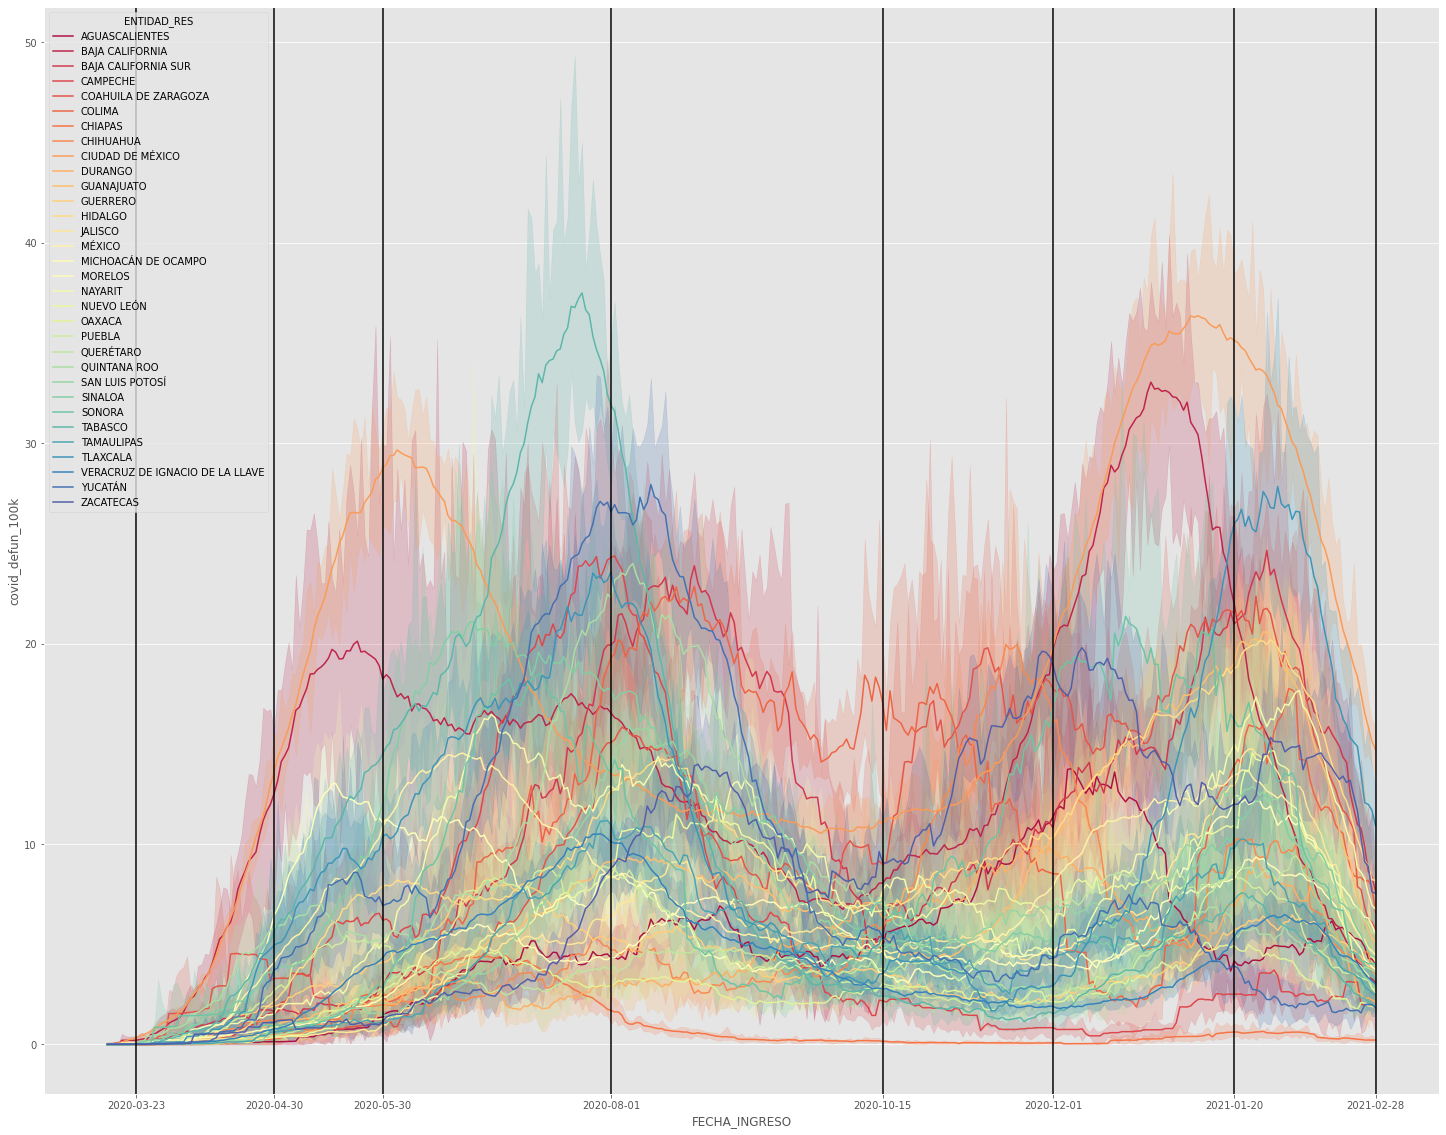

In [67]:
fig, ax = plt.subplots(figsize=(25, 20))
g = sns.lineplot(data=serie,
             x='FECHA_INGRESO', y=f'covid_defun_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)
g.set_xticks(fechas_mpl)
g.set_xticklabels([f.strftime('%Y-%m-%d') for f in fechas])
for fecha in fechas:
    plt.axvline(fecha, 0,1, color='black')
plt.savefig('img/evolucion_mortalidad_entidad.png', bbox_inches='tight')

## Gráfica de serie de tiempo de vulnerabilidad

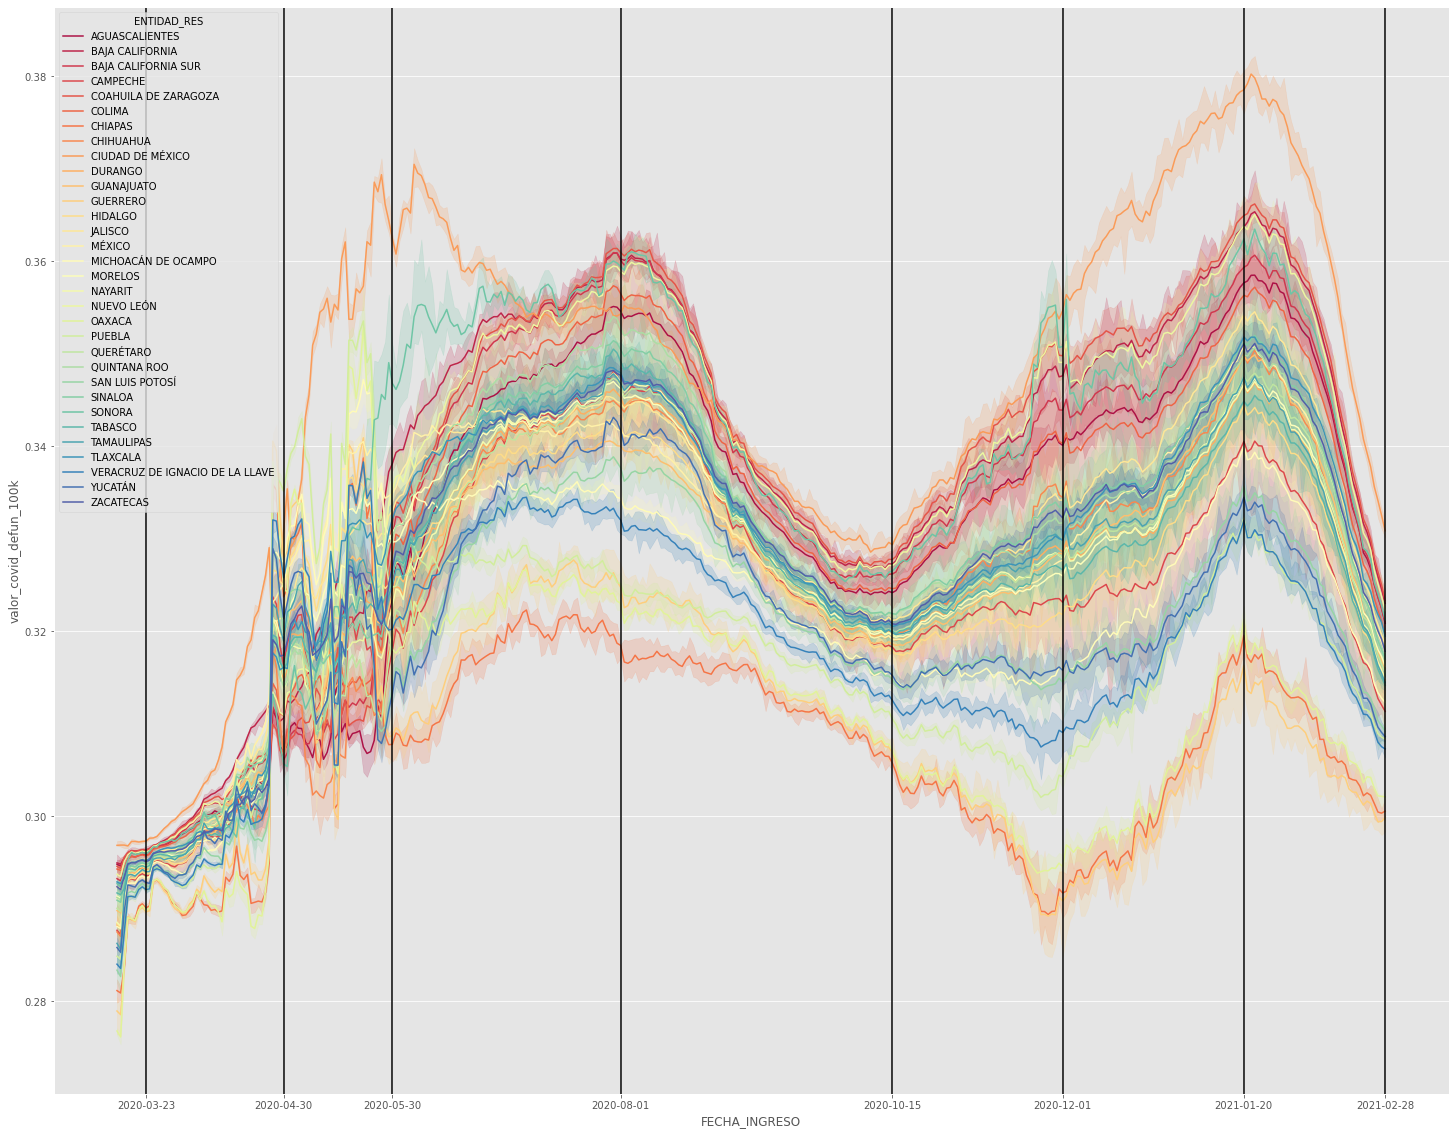

In [66]:
fig, ax = plt.subplots(figsize=(25, 20))
g = sns.lineplot(data=serie,
             x='FECHA_INGRESO', y=f'valor_covid_defun_100k',
             hue='ENTIDAD_RES', palette='Spectral',
             n_boot=10)
g.set_xticks(fechas_mpl)
g.set_xticklabels([f.strftime('%Y-%m-%d') for f in fechas])
for fecha in fechas:
    plt.axvline(fecha, 0,1, color='black')
plt.savefig('img/evolucion_vulnerabilidad_entidad.png', bbox_inches='tight')

## Vulnerabilidad promedio por estado

* etiquetar por intervalo
* promediar para cada intervalo
* extraer las fechas relevantes
* heatmap de rankings

In [73]:
for i, fecha in enumerate(fechas):
    if i == 0:
        serie.loc[serie.FECHA_INGRESO <= fecha, 'intervalo'] = fecha.strftime('%Y-%m-%d')
    else:
        serie.loc[(serie.FECHA_INGRESO > fechas[i-1]) & (serie.FECHA_INGRESO <= fecha), 'intervalo'] = fecha.strftime('%Y-%m-%d') 
serie['media_intervalo'] = (serie
                            .groupby(['intervalo', 'ENTIDAD_RES'])['valor_covid_defun_100k_entidad']
                            .transform('mean')
                            )
serie_momentos = serie[serie.FECHA_INGRESO.isin(fechas)]
entidad_momentos = (serie_momentos[["ENTIDAD_RES", "intervalo", "media_intervalo"]]
                    .groupby(["ENTIDAD_RES", "intervalo"])['media_intervalo']
                    .mean()
                    .reset_index()
                    )
entidad_momentos_wide = (entidad_momentos
                       .pivot(index='ENTIDAD_RES', 
                              columns='intervalo', 
                              values='media_intervalo')
                      )
ranking_entidades = entidad_momentos_wide.rank(ascending=False)
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime) else c for c in ranking_entidades.reset_index().columns]
ranking_entidades = ranking_entidades.reset_index()
ranking_entidades.columns = new_cols
ranking_entidades

ENTIDAD_RES  2020-03-23  2020-04-30  2020-05-30  \
0                    AGUASCALIENTES         4.0        21.0        31.0   
1                   BAJA CALIFORNIA         5.0         4.0        12.0   
2               BAJA CALIFORNIA SUR         8.0        16.0        30.0   
3                          CAMPECHE        22.0        25.0        25.0   
4                           CHIAPAS        31.0        30.0        17.0   
5                         CHIHUAHUA        29.0        31.0        32.0   
6                  CIUDAD DE MÉXICO         2.0         1.0         1.0   
7              COAHUILA DE ZARAGOZA         3.0        10.0        28.0   
8                            COLIMA         7.0        19.0        26.0   
9                           DURANGO        16.0        18.0        27.0   
10                       GUANAJUATO        19.0        13.0        13.0   
11                         GUERRERO        30.0        29.0        11.0   
12                          HIDALGO        24.0         8.0         5.0   
13                          JALISCO         6.0         3.0         8.0   
14              MICHOACÁN DE OCAMPO        26.0        14.0         4.0   
15                          MORELOS        17.0        22.0         7.0   
16                           MÉXICO        13.0         2.0         3.0   
17                          NAYARIT        18.0        17.0        20.0   
18                       NUEVO LEÓN         1.0         5.0        19.0   
19                           OAXACA        32.0        32.0        15.0   
20                           PUEBLA        27.0        11.0         2.0   
21                        QUERÉTARO         9.0        12.0        29.0   
22                     QUINTANA ROO        12.0         9.0        22.0   
23                  SAN LUIS POTOSÍ        25.0        28.0        24.0   
24                          SINALOA        10.0         6.0        16.0   
25                           SONORA        21.0        27.0        23.0   
26                          TABASCO        20.0        24.0        14.0   
27                       TAMAULIPAS        11.0         7.0        10.0   
28                         TLAXCALA        15.0        20.0         9.0   
29  VERACRUZ DE IGNACIO DE LA LLAVE        28.0        26.0         6.0   
30                          YUCATÁN        23.0        15.0        21.0   
31                        ZACATECAS        14.0        23.0        18.0   

    2020-08-01  2020-10-15  2020-12-01  2021-01-20  2021-02-28  
0         10.0         5.0         5.0         5.0         4.0  
1          4.0         3.0         4.0         4.0         5.0  
2          6.0         4.0         7.0         9.0        10.0  
3         19.0        16.0        18.0        22.0        25.0  
4         32.0        31.0        31.0        31.0        31.0  
5         23.0        21.0        15.0        13.0        16.0  
6          1.0         7.0         3.0         1.0         1.0  
7          3.0         2.0         2.0         3.0         3.0  
8          8.0         6.0         8.0        11.0        11.0  
9         15.0        13.0        13.0        15.0        14.0  
10        25.0        25.0        20.0        18.0        18.0  
11        30.0        30.0        30.0        30.0        30.0  
12        24.0        26.0        26.0        25.0        22.0  
13        12.0        15.0        12.0         6.0         6.0  
14        27.0        27.0        27.0        27.0        27.0  
15        17.0        19.0        21.0        20.0        21.0  
16        13.0        24.0        19.0        14.0        13.0  
17        16.0        14.0        16.0        17.0        17.0  
18         2.0         1.0         1.0         2.0         2.0  
19        31.0        32.0        32.0        32.0        32.0  
20        29.0        29.0        29.0        28.0        28.0  
21        14.0        11.0        10.0        10.0         7.0  
22         9.0        12.0        14.0        16.0   

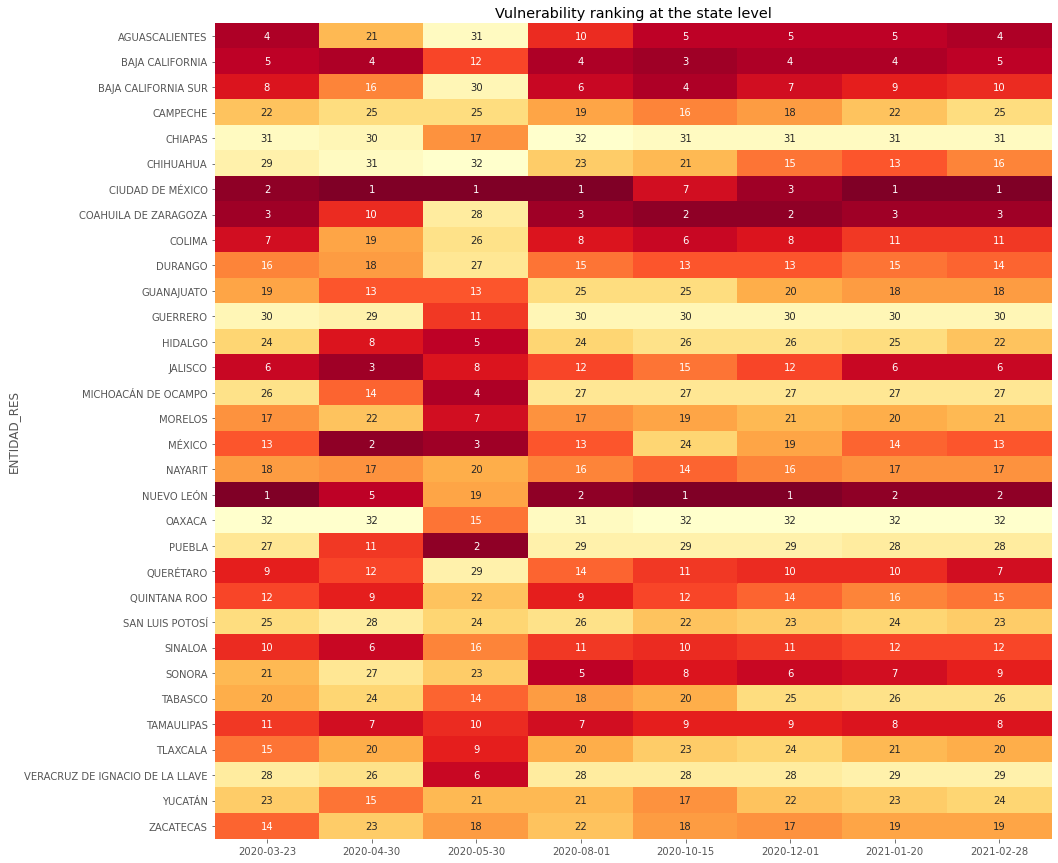

In [94]:
fig, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(ranking_entidades.set_index('ENTIDAD_RES'), cmap="YlOrRd_r", annot=True, cbar=False)
g.set_title(f'Vulnerability ranking at the state level')
plt.savefig('img/evolucion_ranking_vulnerabilidad_entidad.png', bbox_inches='tight')

## Comparación de vulnerabilidad contra mortalidad

Para ver cómo se compara la evolución de la vulnerabilidad con la de la mortalidad y así estar seguros de que estamos capturando algo interesante, vamos a comparar la evolución de los rankings de ambas variables.

In [91]:
serie['media_mortalidad_intervalo'] = (serie
                                       .groupby(['intervalo', 'ENTIDAD_RES'])['defunciones']
                                       .transform('sum')
                                       )
serie['media_mortalidad_intervalo'] = serie['media_mortalidad_intervalo'] / serie['poblacion_entidad']
serie_momentos = serie[serie.FECHA_INGRESO.isin(fechas)]
entidad_momentos = (serie_momentos[["ENTIDAD_RES", "intervalo", "media_intervalo", "media_mortalidad_intervalo"]]
                    .groupby(["ENTIDAD_RES", "intervalo"])['media_intervalo', 'media_mortalidad_intervalo']
                    .mean()
                    .reset_index()
                    )
entidad_momentos_mortalidad_wide = (entidad_momentos
                       .pivot(index='ENTIDAD_RES', 
                              columns='intervalo', 
                              values='media_mortalidad_intervalo')
                      )
ranking_entidades_mortalidad = entidad_momentos_mortalidad_wide.rank(ascending=False)
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime) else c for c in ranking_entidades_mortalidad.reset_index().columns]
ranking_entidades_mortalidad = ranking_entidades_mortalidad.reset_index()
ranking_entidades_mortalidad.columns = new_cols
ranking_entidades_mortalidad

/home/datalab/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


ENTIDAD_RES  2020-03-23  2020-04-30  2020-05-30  \
0                    AGUASCALIENTES        27.5        21.0        23.0   
1                   BAJA CALIFORNIA        13.0         1.0         2.0   
2               BAJA CALIFORNIA SUR         2.0         9.0        21.0   
3                          CAMPECHE        27.5        15.0        15.0   
4                           CHIAPAS        22.0        32.0        24.0   
5                         CHIHUAHUA        19.0         8.0        10.0   
6                  CIUDAD DE MÉXICO         1.0         2.0         1.0   
7              COAHUILA DE ZARAGOZA         8.0        13.0        29.0   
8                            COLIMA        27.5        29.0        25.0   
9                           DURANGO         3.0        26.0        26.0   
10                       GUANAJUATO        27.5        25.0        28.0   
11                         GUERRERO        27.5        17.0        11.0   
12                          HIDALGO        11.0        14.0         9.0   
13                          JALISCO        12.0        30.0        31.0   
14              MICHOACÁN DE OCAMPO        21.0        19.0        20.0   
15                          MORELOS         5.0         7.0         3.0   
16                           MÉXICO         9.0         6.0         7.0   
17                          NAYARIT        27.5        18.0        19.0   
18                       NUEVO LEÓN        14.0        27.0        27.0   
19                           OAXACA        27.5        28.0        17.0   
20                           PUEBLA        15.0        10.0        13.0   
21                        QUERÉTARO        20.0        23.0        18.0   
22                     QUINTANA ROO         4.0         3.0         5.0   
23                  SAN LUIS POTOSÍ        10.0        31.0        30.0   
24                          SINALOA         7.0         4.0         6.0   
25                           SONORA        27.5        16.0        16.0   
26                          TABASCO        16.0         5.0         4.0   
27                       TAMAULIPAS        18.0        22.0        22.0   
28                         TLAXCALA        27.5        11.0         8.0   
29  VERACRUZ DE IGNACIO DE LA LLAVE        27.5        20.0        12.0   
30                          YUCATÁN        17.0        12.0        14.0   
31                        ZACATECAS         6.0        24.0        32.0   

    2020-08-01  2020-10-15  2020-12-01  2021-01-20  2021-02-28  
0         26.0        16.0         5.0        10.0        19.0  
1          7.0        18.0        10.0         2.0        17.0  
2         22.0         4.0        18.0        16.0         8.0  
3          4.0        15.0        31.0        31.0        31.0  
4         29.0        32.0        32.0        32.0        32.0  
5         28.0        28.0         1.0        17.0        30.0  
6          5.0        13.0         7.0         1.0         1.0  
7         18.0         7.0         2.0         3.0         7.0  
8         19.0         1.0        12.0        28.0        18.0  
9         30.0        26.0         4.0        14.0        27.0  
10        16.0        19.0        15.0         5.0         4.0  
11        13.0        29.0        24.0        27.0        22.0  
12        17.0        12.0         9.0         4.0         2.0  
13        25.0        24.0        13.0        11.0         5.0  
14        31.0        25.0        22.0        21.0        16.0  
15        21.0        30.0        26.0        23.0        15.0  
16        11.0        27.0        17.0         9.0        10.0  
17        15.0        10.0        21.0        22.0        12.0  
18        23.0         5.0         6.0        13.0         9.0  
19        20.0        31.0        28.0        29.0        28.0  
20        12.0        20.0        23.0        18.0        14.0  
21        27.0        21.0        11.0         8.0        11.0  
22         9.0         6.0        25.0        26.0   

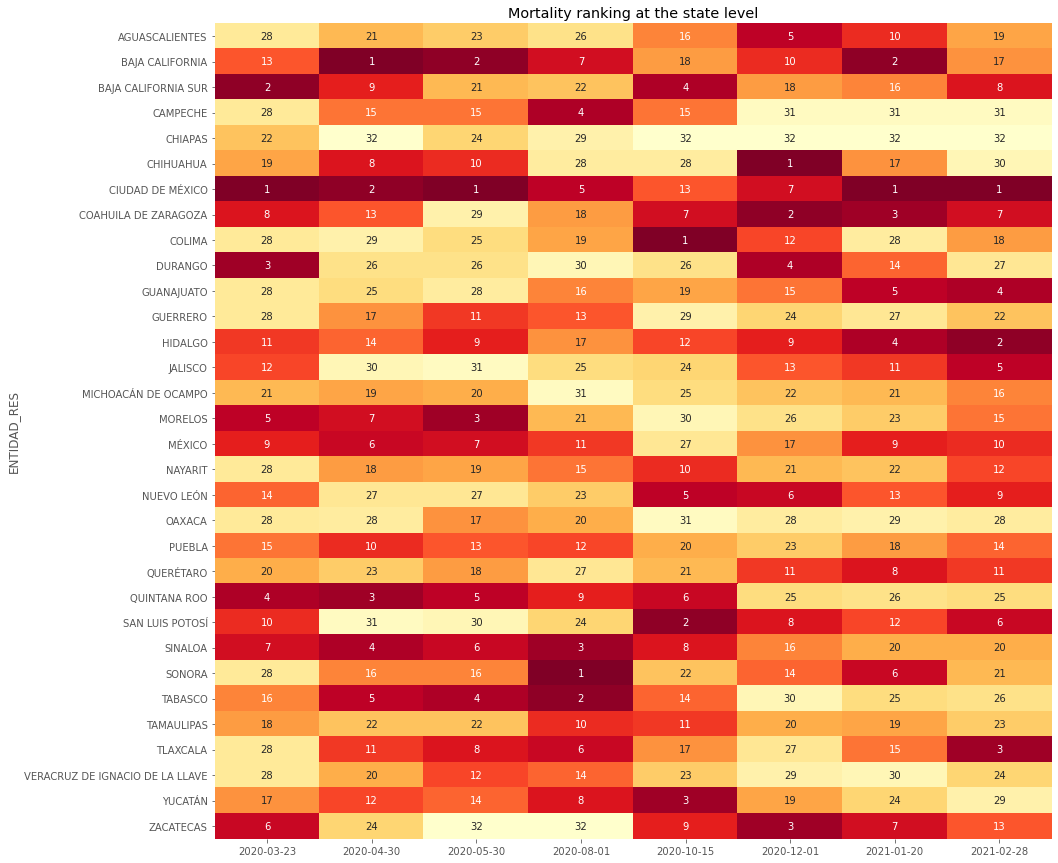

In [95]:
fig, ax = plt.subplots(figsize=(15, 15))
g = sns.heatmap(ranking_entidades_mortalidad.set_index('ENTIDAD_RES'), cmap="YlOrRd_r", annot=True, cbar=False)
g.set_title(f'Mortality ranking at the state level')
plt.savefig('img/evolucion_ranking_mortalidad_entidad.png', bbox_inches='tight')

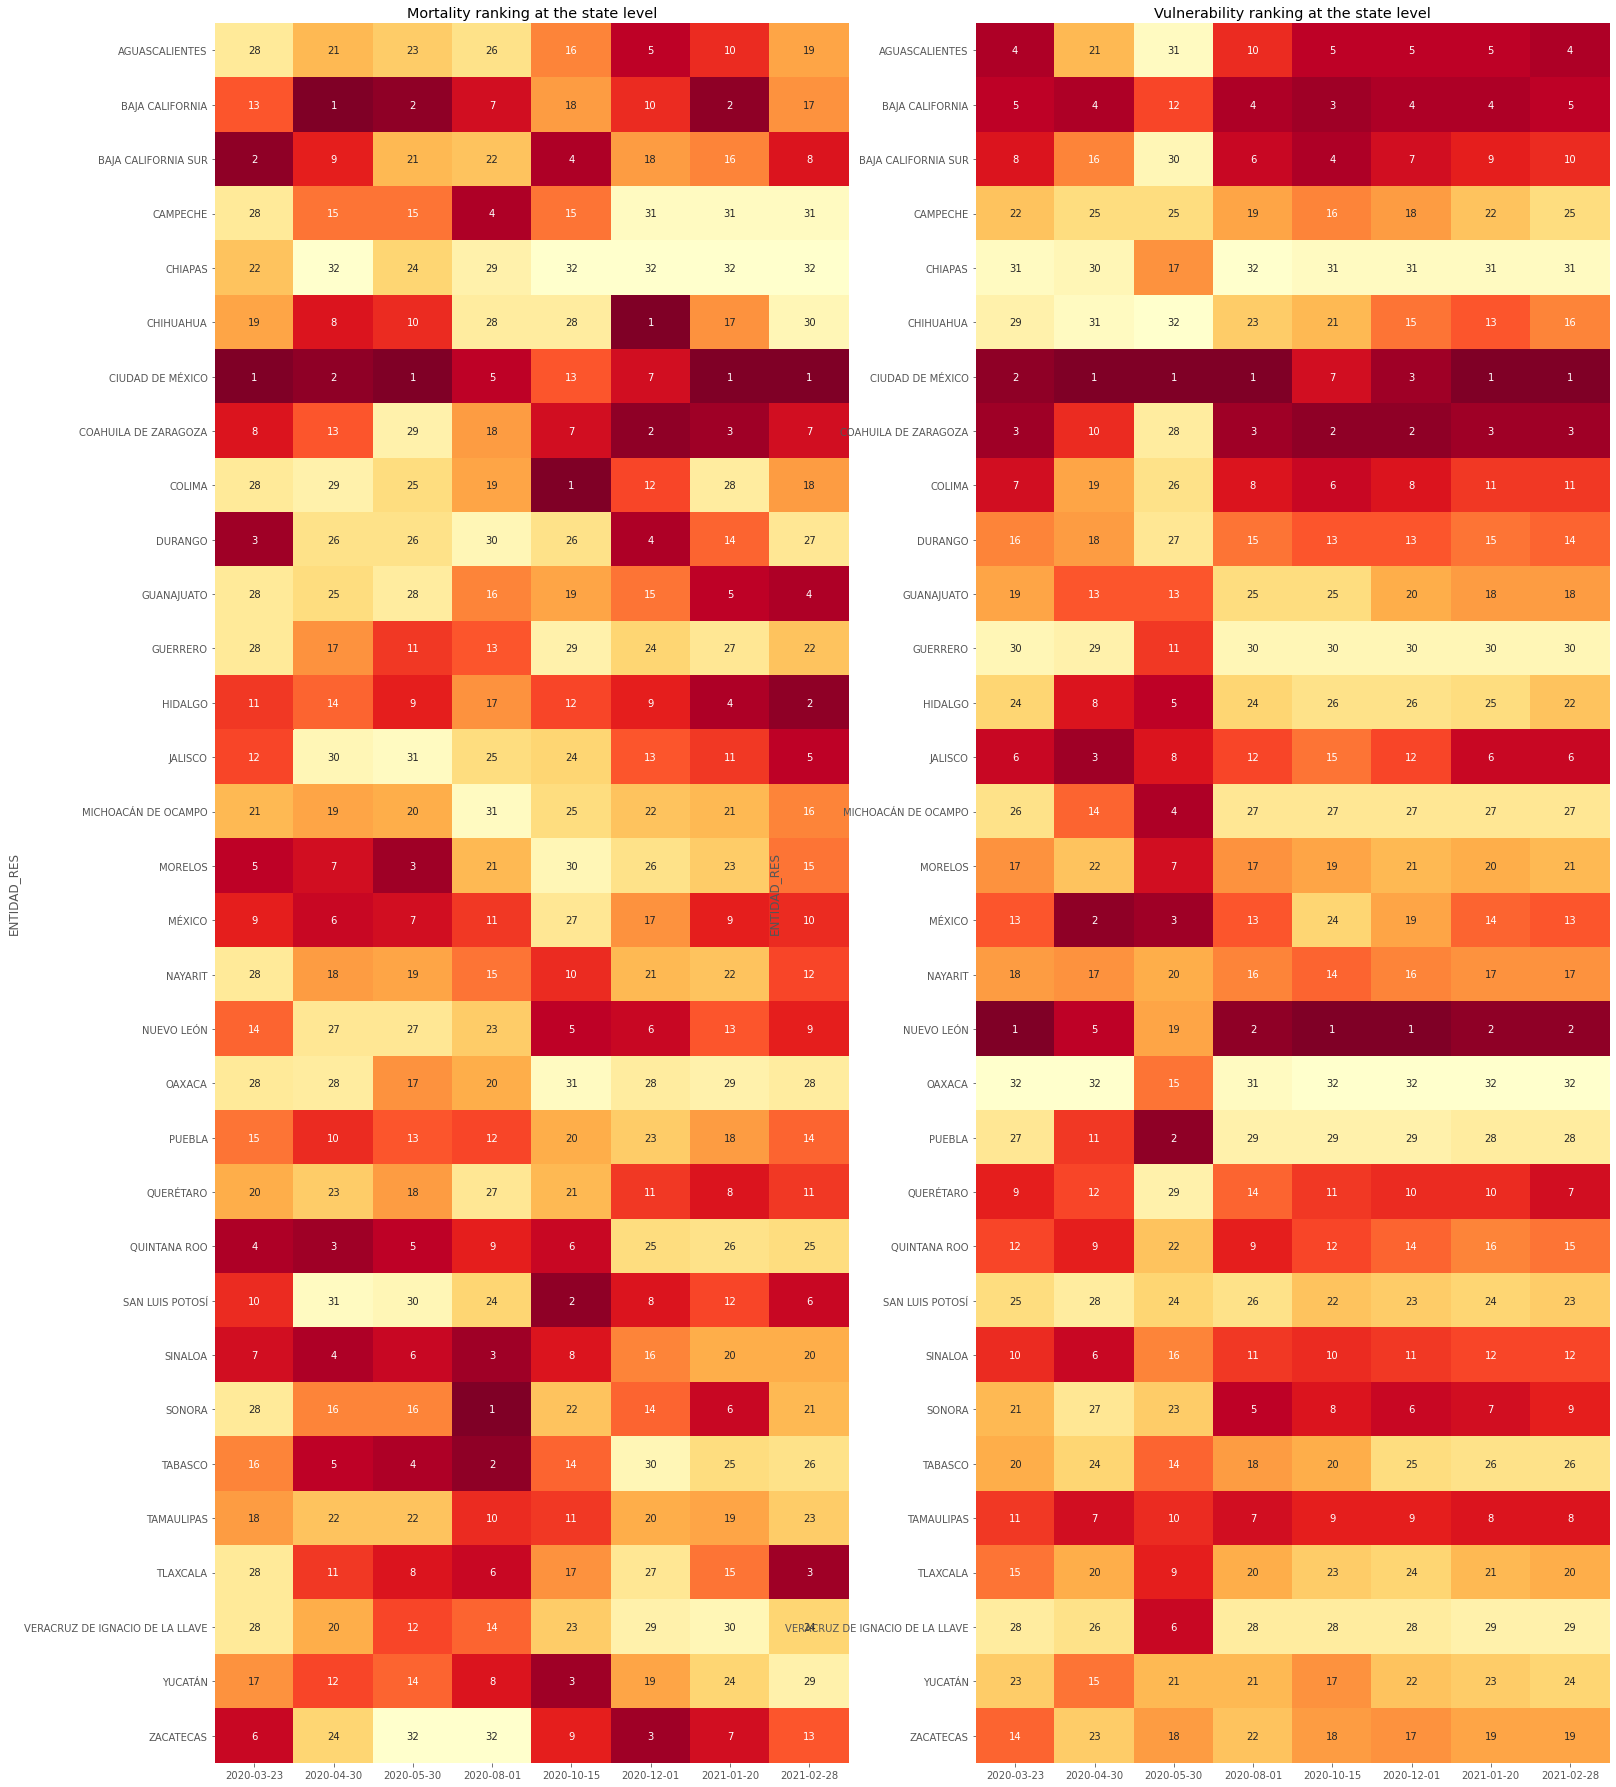

In [164]:
f, axes = plt.subplots(1,2,figsize=(25, 32))
axes = axes.ravel()
g = sns.heatmap(ranking_entidades_mortalidad.set_index('ENTIDAD_RES'), cmap="YlOrRd_r", annot=True, cbar=False, ax=axes[0])
g.set_title(f'Mortality ranking at the state level')
g = sns.heatmap(ranking_entidades.set_index('ENTIDAD_RES'), cmap="YlOrRd_r", annot=True, cbar=False,ax=axes[1])
g.set_title(f'Vulnerability ranking at the state level')
plt.savefig('img/comparacion_evolucion_ranking_mortalidad_vulnerabilidad_entidad.png', bbox_inches='tight')

## Importancia de variables

In [143]:
dimensiones = pd.read_csv("datos/diccionario_variables_usadas.csv")
for i, fecha in enumerate(fechas):
    if i == 0:
        modelos.loc[modelos.dia_ajuste <= fecha, 'intervalo'] = fecha.strftime('%Y-%m-%d')
    else:
        modelos.loc[(modelos.dia_ajuste > fechas[i-1]) & (modelos.dia_ajuste <= fecha), 'intervalo'] = fecha.strftime('%Y-%m-%d')
        
modelos['media_intervalo'] = modelos.groupby(['intervalo', 'caracteristica'])['coef'].transform('mean')
modelos_momentos = modelos[modelos.dia_ajuste.isin(fechas)]
modelos_momentos = modelos_momentos.merge(dimensiones, left_on='caracteristica', right_on='campo').drop(columns=['campo', 'descriptor', 'caracteristica'])
modelos_momentos = modelos_momentos.drop(columns='coef')
modelos_momentos_wide = (modelos_momentos
                    .pivot(index=['display_name', 'dimension'],
                           columns='dia_ajuste',
                           values='media_intervalo')
                    )
ranking_variables = (modelos_momentos_wide
                     .groupby('dimension')
                     .rank(ascending=False)
                     .reset_index()
                     )
new_cols = [c.strftime('%Y-%m-%d') if isinstance(c, datetime)
            else c for c in ranking_variables.columns]
ranking_variables.columns = new_cols

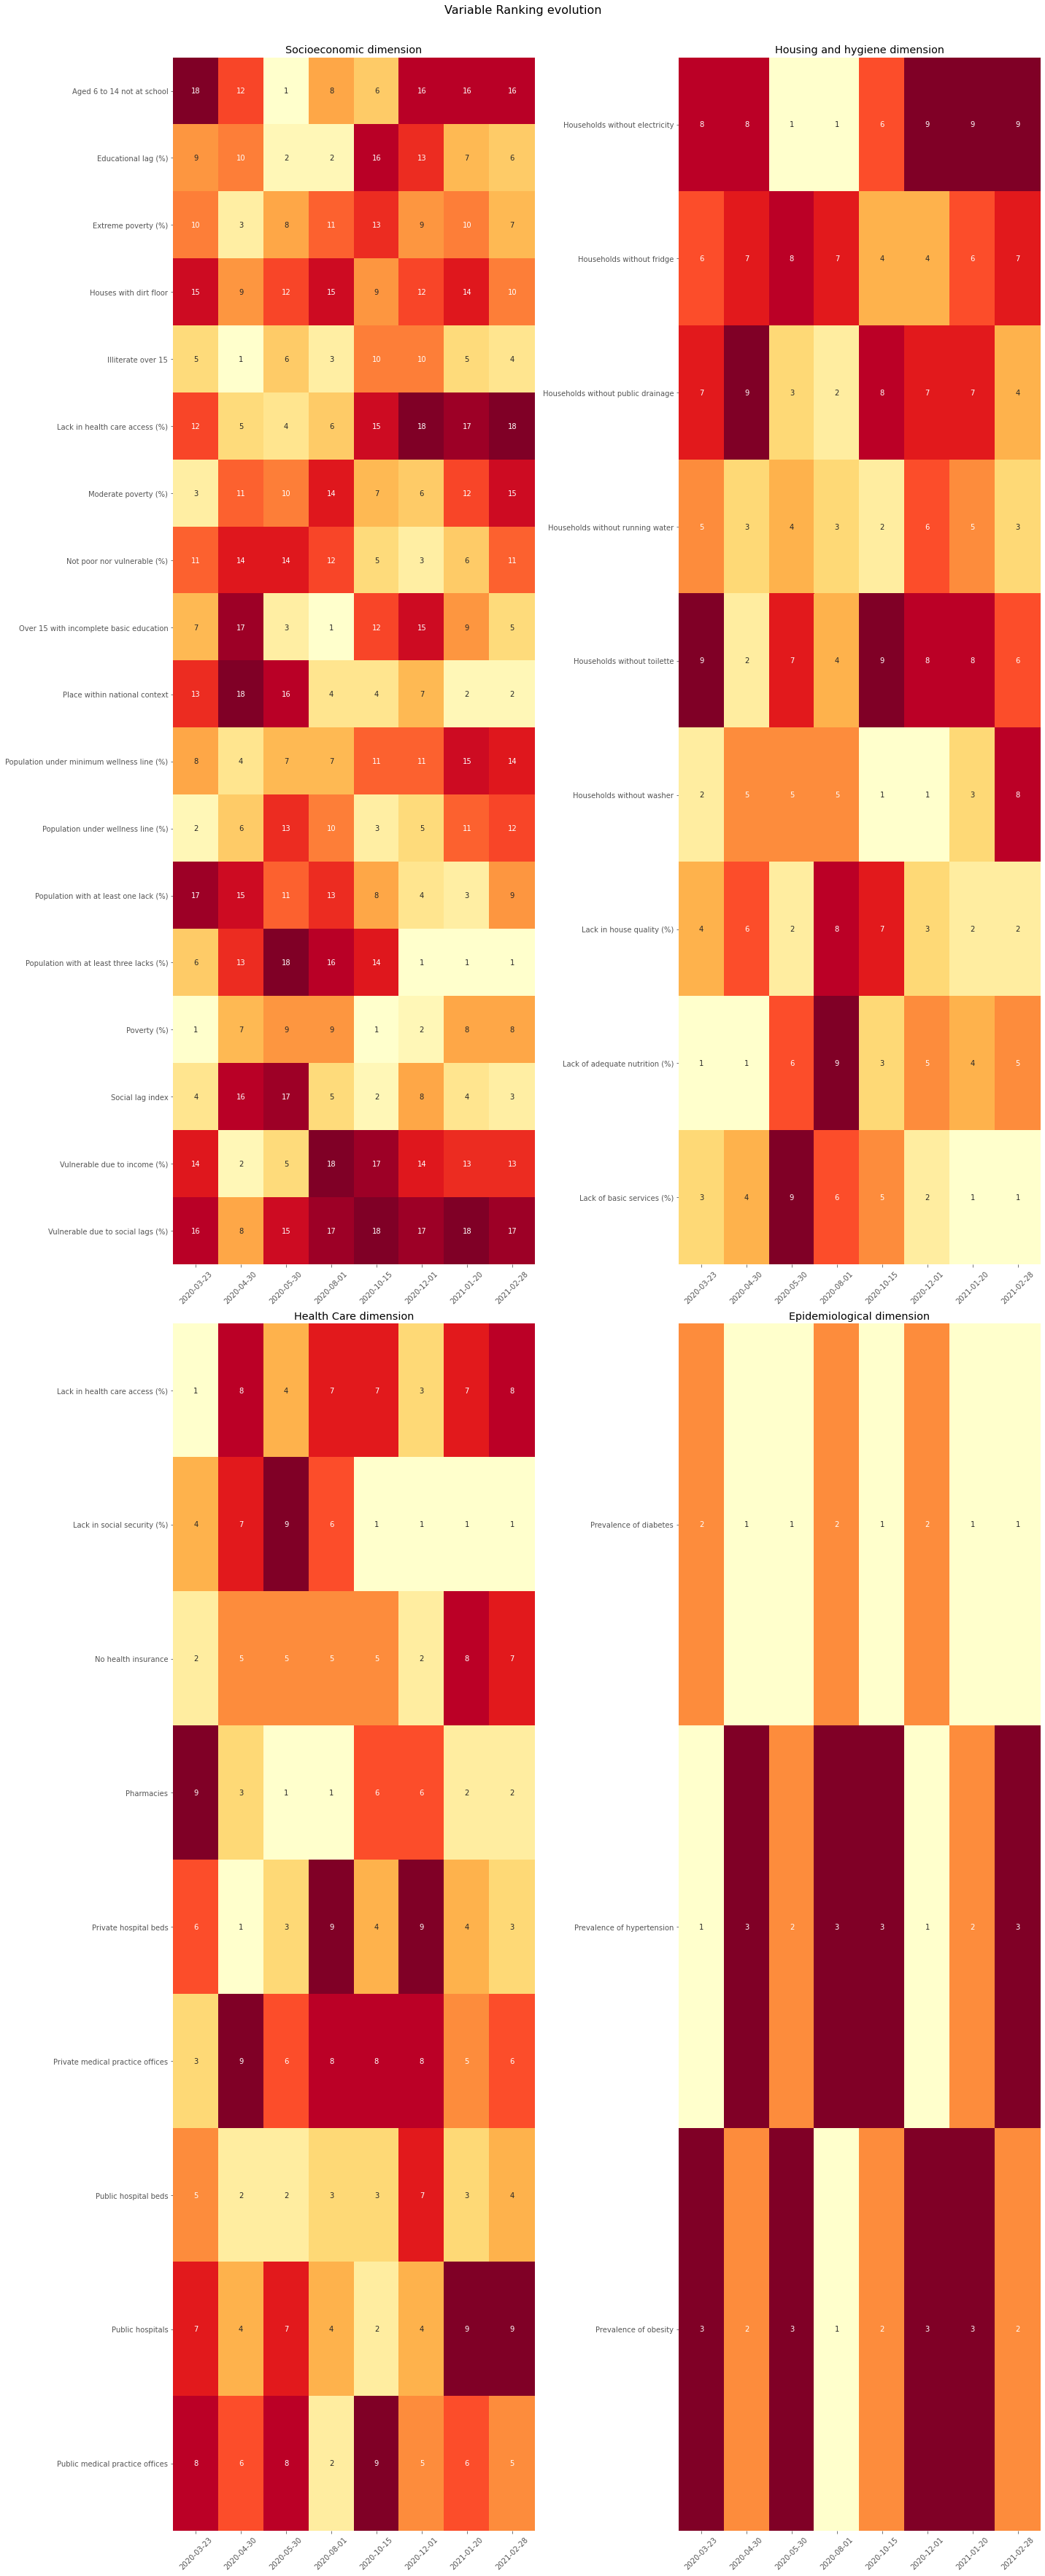

In [165]:
f, axes = plt.subplots(2,2,figsize=(20, 50))
f.suptitle('Variable Ranking evolution', fontsize=16)
lista_dimensiones = ranking_variables.dimension.unique()
axes = axes.ravel()
for i, dimension in enumerate(lista_dimensiones):
    df = ranking_variables[ranking_variables.dimension == dimension]
    g = sns.heatmap(df.drop(columns='dimension').set_index('display_name'), 
                    cmap="YlOrRd", ax=axes[i], cbar=False, annot=True)
    g.set_title(f'{dimension} dimension')
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)
    axes[i].set_ylabel('')    
    axes[i].set_xlabel('')
f.tight_layout()
f.subplots_adjust(top=0.96)
plt.savefig('img/heatmap_evolucion_importancia_por_dimension.png')

## Mapas

* Evolución a nivel estatal
* Evolución municipal para estados específicos

### Mapas estatales

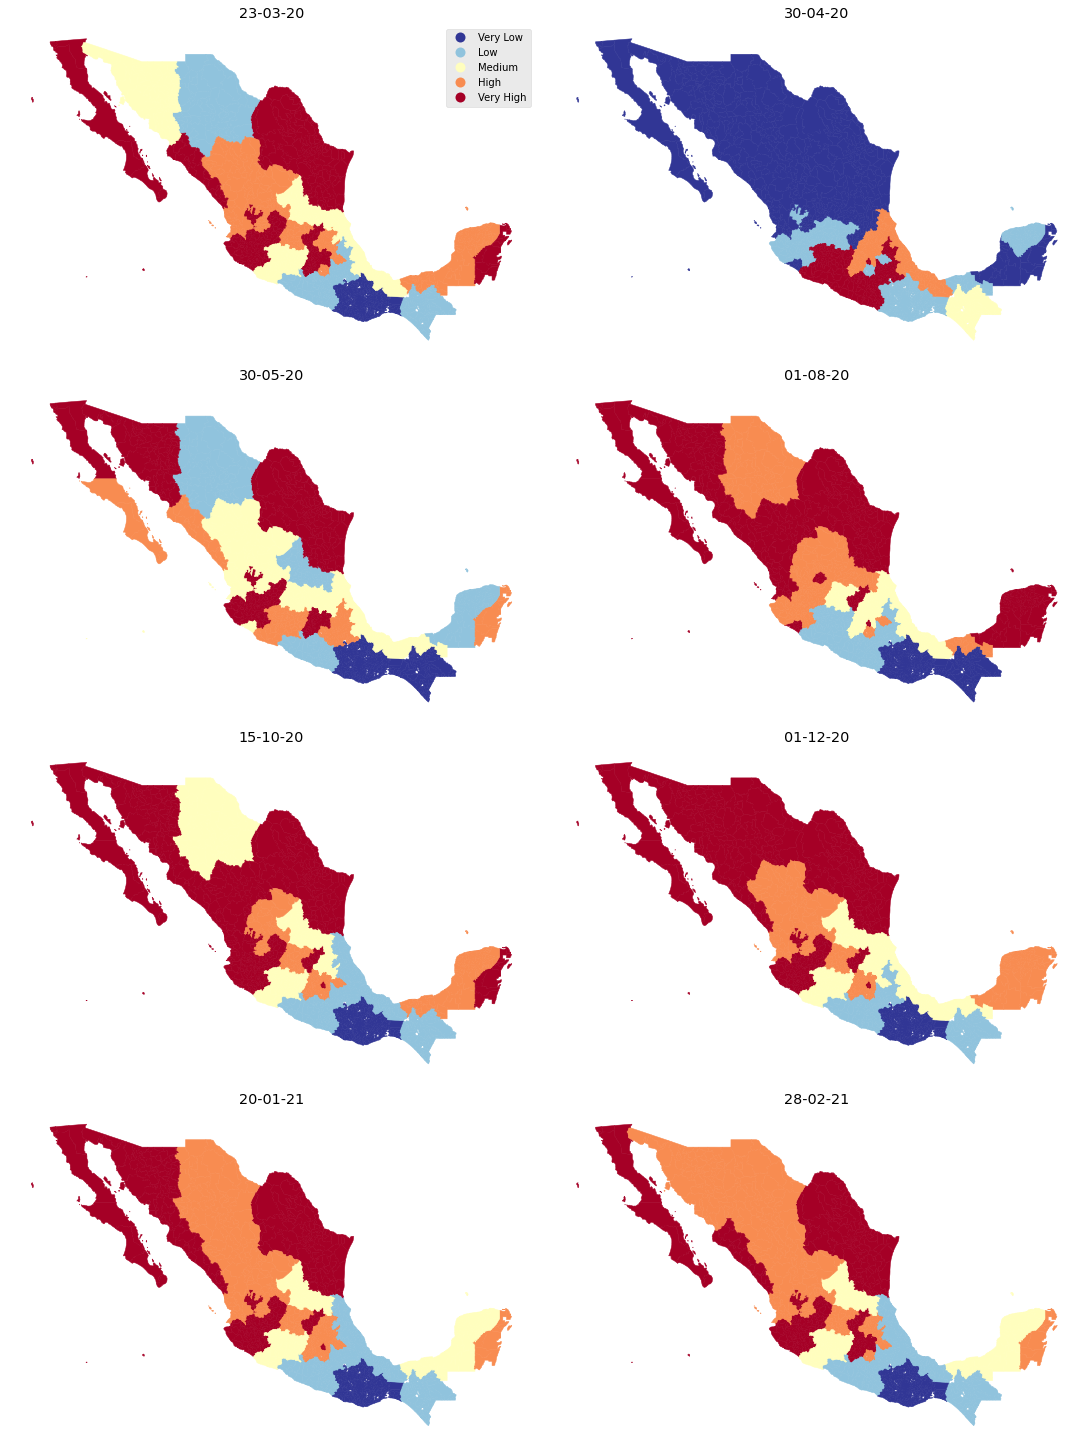

In [171]:
fig, axes = plt.subplots(4,2,figsize=(15, 20), constrained_layout=True)
axes = axes.ravel()
legend_labels=[
            'Very Low',
            'Low',
            'Medium',
            'High',
            'Very High'
]
for i, fecha in enumerate(fechas):
    vulnerabilidad_entidad = serie[serie.FECHA_INGRESO == fecha]
    vulnerabilidad_entidad = vulnerabilidad_entidad[['ENTIDAD_RES','geometry', 'valor_covid_defun_100k_entidad']]
    legend = True if i == 0 else False
    f = vulnerabilidad_entidad.plot(ax=axes[i], column='valor_covid_defun_100k_entidad', cmap='RdYlBu_r',
                                    scheme="Quantiles", legend=legend, k=5,
                                    edgecolor="face")
    axes[i].set_axis_off()
    if legend:
        l = axes[i].get_legend()
        for text, label in zip(l.get_texts(), legend_labels):
            text.set_text(label)
    f.set_title(fecha.strftime("%d-%m-%y"))
plt.savefig('img/mapa_evolucion_vulnerabilidad_entidades.png')

### Mapas municipales

In [176]:
 def mapa_municipal_entidad(datos, fecha, entidad, ax, legend=True):
    df = datos[(serie.FECHA_INGRESO == fecha) & (serie.ENTIDAD_RES == entidad)]
    m = df.plot(column='valor_covid_defun_100k', cmap='RdYlBu_r',
            scheme="Quantiles", legend=legend, k=5, ax=ax)
    return m 

#### Chiapas

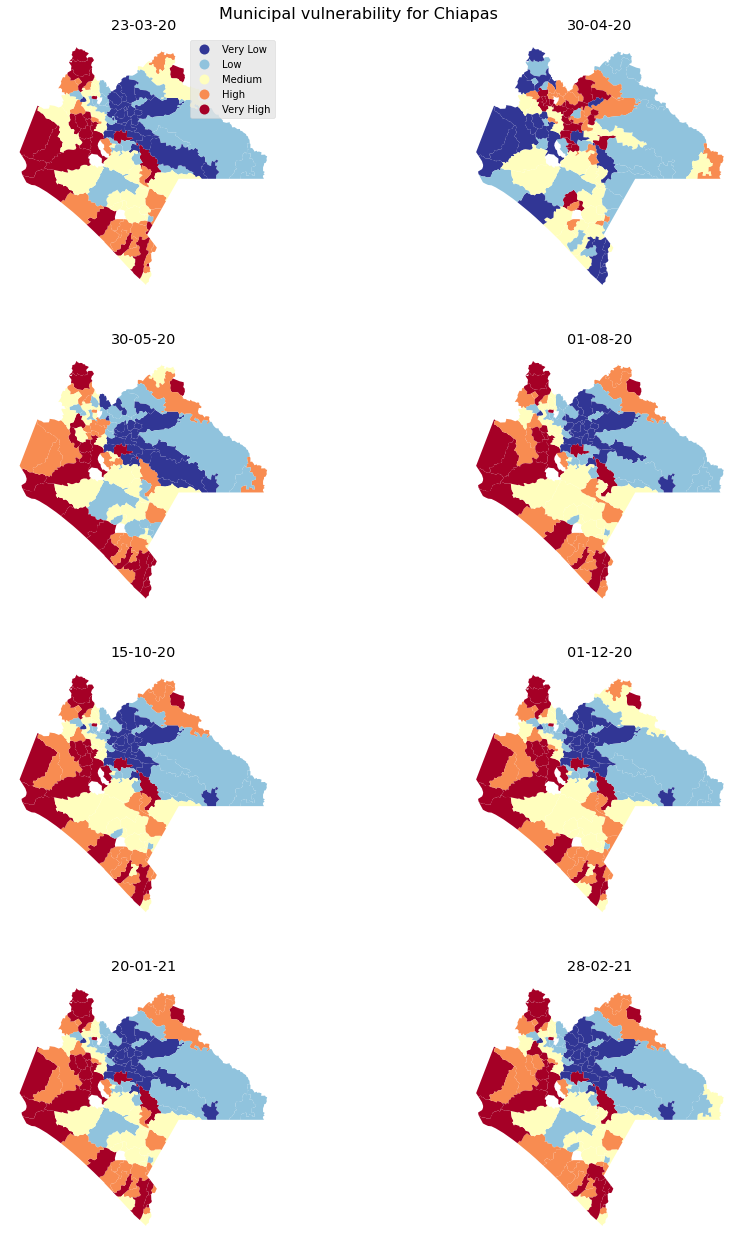

In [173]:
fig, axes = plt.subplots(4,2,figsize=(15, 20))
fig.suptitle('Municipal vulnerability for Chiapas', fontsize=16)
axes = axes.ravel()
legend_labels=[
            'Very Low',
            'Low',
            'Medium',
            'High',
            'Very High'
]
for i, fecha in enumerate(fechas):
    legend = True if i == 0 else False
    m = mapa_municipal_entidad(serie, fecha, "CHIAPAS", axes[i], legend)
    axes[i].set_axis_off()
    if legend:
        l = axes[i].get_legend()
        for text, label in zip(l.get_texts(), legend_labels):
            text.set_text(label)
    m.set_title(f'{fecha.strftime("%d-%m-%y")}')
fig.subplots_adjust(top=0.96)
plt.savefig('img/mapa_evolucion_vulnerabilidad_chiapas.png')

#### Tamaulipas

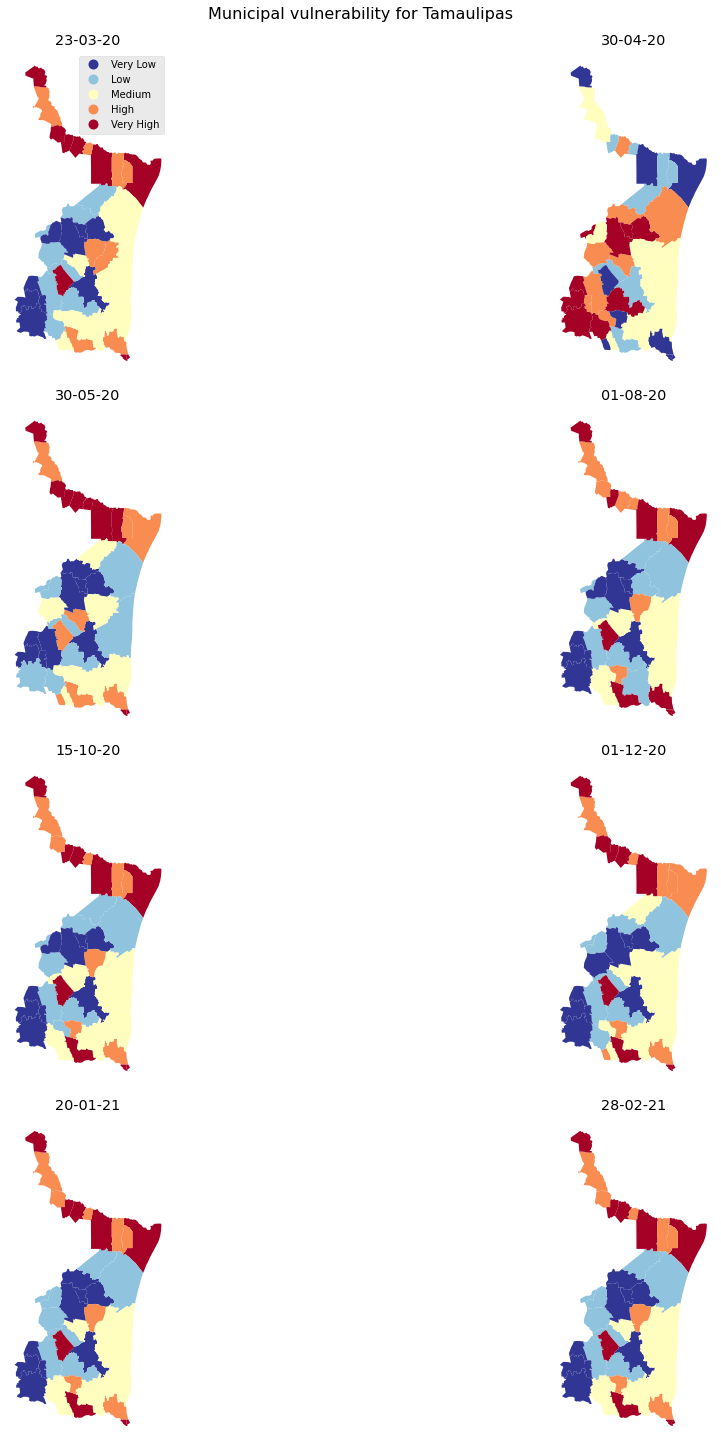

In [175]:
fig, axes = plt.subplots(4,2,figsize=(15, 20), constrained_layout=True)
fig.suptitle('Municipal vulnerability for Tamaulipas', fontsize=16)
axes = axes.ravel()
legend_labels=[
            'Very Low',
            'Low',
            'Medium',
            'High',
            'Very High'
]
for i, fecha in enumerate(fechas):
    legend = True if i == 0 else False
    m = mapa_municipal_entidad(serie, fecha, "TAMAULIPAS", axes[i], legend)
    axes[i].set_axis_off()
    if legend:
        l = axes[i].get_legend()
        for text, label in zip(l.get_texts(), legend_labels):
            text.set_text(label)
    m.set_title(f'{fecha.strftime("%d-%m-%y")}')
plt.savefig('img/mapa_evolucion_vulnerabilidad_tamaulipas.png')

#### Veracruz

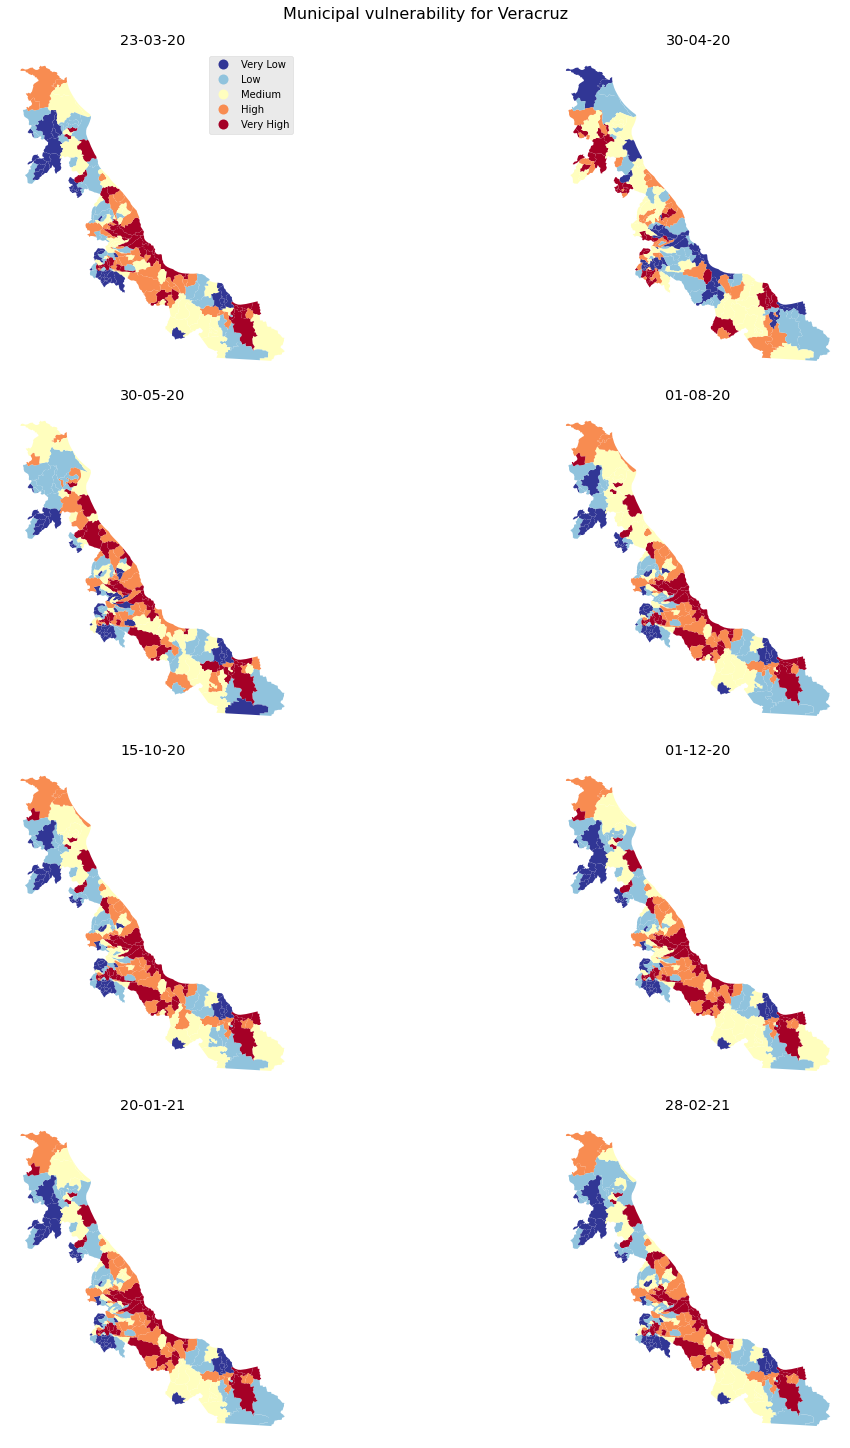

In [178]:
fig, axes = plt.subplots(4,2,figsize=(15, 20), constrained_layout=True)
fig.suptitle('Municipal vulnerability for Veracruz', fontsize=16)
axes = axes.ravel()
legend_labels=[
            'Very Low',
            'Low',
            'Medium',
            'High',
            'Very High'
]
for i, fecha in enumerate(fechas):
    legend = True if i == 0 else False
    m = mapa_municipal_entidad(serie, fecha, "VERACRUZ DE IGNACIO DE LA LLAVE", axes[i], legend)
    axes[i].set_axis_off()
    if legend:
        l = axes[i].get_legend()
        for text, label in zip(l.get_texts(), legend_labels):
            text.set_text(label)
    m.set_title(f'{fecha.strftime("%d-%m-%y")}')
plt.savefig('img/mapa_evolucion_vulnerabilidad_veracruz.png')

#### CDMX

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15, 20), constrained_layout=True)
fig.suptitle('Municipal vulnerability for CDMX', fontsize=16)
axes = axes.ravel()
legend_labels=[
            'Very Low',
            'Low',
            'Medium',
            'High',
            'Very High'
]
for i, fecha in enumerate(fechas):
    legend = True if i == 0 else False
    m = mapa_municipal_entidad(serie, fecha, "VERACRUZ DE IGNACIO DE LA LLAVE", axes[i], legend)
    axes[i].set_axis_off()
    if legend:
        l = axes[i].get_legend()
        for text, label in zip(l.get_texts(), legend_labels):
            text.set_text(label)
    m.set_title(f'{fecha.strftime("%d-%m-%y")}')
plt.savefig('img/mapa_evolucion_vulnerabilidad_veracruz.png')